## LandCoverNet Source Imagery Extraction

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.



In [1]:
import getpass

MLHUB_API_KEY = getpass.getpass(prompt="MLHub API Key: ")
MLHUB_ROOT_URL = "https://api.radiant.earth/mlhub/v1"

MLHub API Key:  ································································


In [155]:
# MLHUB_API_KEY

In [4]:
# !pip install stackstac

In [2]:
import pystac
import os
import itertools as it
import pystac_client
import requests
import shapely.geometry
import rioxarray
from pystac import Item
import planetary_computer
import stackstac
import rasterio.plot
import numpy as np
import dask

import contextlib
import warnings
from pystac.extensions.label import LabelExtension, LabelRelType
from pystac.item_collection import ItemCollection
from urllib.parse import urljoin

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

In [3]:
class MLHubSession(requests.Session):
    def __init__(self, *args, api_key=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.params.update({"key": api_key})

    def request(self, method, url, *args, **kwargs):
        url_prefix = MLHUB_ROOT_URL.rstrip("/") + "/"
        url = urljoin(url_prefix, url)
        return super().request(method, url, *args, **kwargs)


session = MLHubSession(api_key=MLHUB_API_KEY)

In [4]:
# tmp_dir = "/home/jovyan/PlanetaryComputerExamples"
tmp_dir = "/Users/kendallsmith/radiant"
if not os.path.isdir(f"{tmp_dir}/landcovnet/labels"):
    os.makedirs(f"{tmp_dir}/landcovnet/labels") #create folder for labels to be stored

### Loading the source imagery

The esip-summer-2021-geospatial-ml tutorial was helpful in this task, which can be found at 

https://github.com/TomAugspurger/esip-summer-2021-geospatial-ml/blob/main/segmentation-model.ipynb

In [52]:
training_catalog = pystac.read_file(
    tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/collection.json"
)

In [127]:
from dask.distributed import Client

client = Client()
client.run(lambda: warnings.filterwarnings("ignore", "Creating an ndarray from ragged"))
client

/Users/kendallsmith/opt/anaconda3/envs/mlhub/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57256 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/Users/kendallsmith/scalable-model-training/dask-worker-space/worker-061kv7e5', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/kendallsmith/scalable-model-training/dask-worker-space/worker-d5rtubsf', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/kendallsmith/scalable-model-training/dask-worker-space/worker-bhqftibj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/kendallsmith/scalable-model-training/dask-worker-space/worker-iwvd628c', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57256/status,
Dashboard: http://127.0.0.1:57256/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57257,Workers: 4
Dashboard: http://127.0.0.1:57256/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:57269,Total threads: 2
Dashboard: http://127.0.0.1:57274/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:57260,


In [53]:
links = training_catalog.get_item_links()

In [67]:
training_catalog.to_dict()

{'type': <STACObjectType.COLLECTION: 'Collection'>,
 'id': 'ref_landcovernet_v1_labels',
 'stac_version': '1.0.0',
 'description': 'LandCoverNet Labels',
 'links': [{'rel': <RelType.ROOT: 'root'>,
   'href': './collection.json',
   'type': <MediaType.JSON: 'application/json'>},
  {'rel': <RelType.SELF: 'self'>,
   'href': '/Users/kendallsmith/radiant/landcovnet/labels/ref_landcovernet_v1_labels/collection.json',
   'type': <MediaType.JSON: 'application/json'>},
  {'rel': 'item', 'href': './ref_landcovernet_v1_labels_37PCM_22/stac.json'},
  {'rel': 'item', 'href': './ref_landcovernet_v1_labels_35PNR_13/stac.json'},
  {'rel': 'item', 'href': './ref_landcovernet_v1_labels_34MBC_18/stac.json'},
  {'rel': 'item', 'href': './ref_landcovernet_v1_labels_37NGE_11/stac.json'},
  {'rel': 'item', 'href': './ref_landcovernet_v1_labels_33KXV_06/stac.json'},
  {'rel': 'item', 'href': './ref_landcovernet_v1_labels_35PNR_11/stac.json'},
  {'rel': 'item', 'href': './ref_landcovernet_v1_labels_32PLS_01/s

In [54]:
len(links)

1980

In [55]:
links[0:5]

[<Link rel=item target=ref_landcovernet_v1_labels_37PCM_22/stac.json>,
 <Link rel=item target=ref_landcovernet_v1_labels_35PNR_13/stac.json>,
 <Link rel=item target=ref_landcovernet_v1_labels_34MBC_18/stac.json>,
 <Link rel=item target=ref_landcovernet_v1_labels_37NGE_11/stac.json>,
 <Link rel=item target=ref_landcovernet_v1_labels_33KXV_06/stac.json>]

In [56]:
links[0].get_target_str()

'ref_landcovernet_v1_labels_37PCM_22/stac.json'

In [57]:
links[0].get_absolute_href()

'/Users/kendallsmith/radiant/landcovnet/labels/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_37PCM_22/stac.json'

In [58]:
N_SCENES = 100
links = training_catalog.get_item_links()[:N_SCENES]
label_items = [link.resolve_stac_object().target for link in links]

In [12]:
label_item = next(training_catalog.get_all_items())

In [68]:
label_item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'ref_landcovernet_v1_labels_35PNR_20',
 'properties': {'datetime': '2018-07-01T00:00:00Z',
  'label:classes': [{'classes': ['No Data',
     'Water',
     'Artificial Bareground',
     'Natural Bareground',
     'Permanent Snow/Ice',
     'Woody Vegetation',
     'Cultivated Vegetation',
     '(Semi) Natural Vegetation'],
    'name': 'labels'}],
  'label:description': 'Land Cover Type Classification',
  'label:properties': ['labels'],
  'label:type': 'raster',
  'labels': ['Artificial Bareground',
   'Natural Bareground',
   'Woody Vegetation',
   'Cultivated Vegetation',
   '(Semi) Natural Vegetation']},
 'geometry': {'coordinates': [[[27.37139581450493, 13.516544267127598],
    [27.371431689105854, 13.53969217566714],
    [27.395090549888636, 13.539655924211914],
    [27.395052390345352, 13.516508079922641],
    [27.37139581450493, 13.516544267127598]]],
  'type': 'Polygon'},
 'links': [{'rel': 'collection', 'href': '../collection.j

In [13]:
sample_im = rasterio.open(tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/"+label_item.id+"/labels.tif")

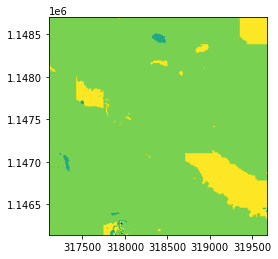

In [14]:
rasterio.plot.show(sample_im);

In [137]:
sample_bounds = sample_im.bounds
sample_bounds

BoundingBox(left=317110.0, bottom=1146140.0, right=319670.0, top=1148700.0)

In [138]:
sample_epsg = sample_im.crs.to_epsg()
sample_epsg

32637

In [139]:
label_item.geometry

{'coordinates': [[[37.32955714822882, 10.364020025810353],
   [37.3294343663916, 10.387163703120759],
   [37.35281134371039, 10.38728455271804],
   [37.35293240931304, 10.364140600401992],
   [37.32955714822882, 10.364020025810353]]],
 'type': 'Polygon'}

In [20]:
from ipyleaflet import Map, GeoJSON

data = {
    "type": "FeatureCollection",
    "features": [],
}
for label_item in label_items:
    data["features"].append(label_item.geometry)


center = shapely.geometry.shape(label_item.geometry).centroid.bounds[:2][::-1]

m = Map(center=(5.507814018809909, 13.617742928307308), zoom=2)
layer = GeoJSON(data=data)

m.add_layer(layer)
m.layout.max_width = "600px"

m

Map(center=[5.507814018809909, 13.617742928307308], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [15]:
# all the labels are from the same datetime
set([label_item.datetime for label_item in label_items])

{datetime.datetime(2018, 7, 1, 0, 0, tzinfo=tzutc())}

In [140]:
bboxes = np.array([label_item.bbox for label_item in label_items])
mins = bboxes.min(0)
maxes = bboxes.max(0)
bbox = mins[0], mins[1], maxes[2], maxes[3]

In [15]:
def find_match(label_item, sentinel_items):
    # make sure we pick a sentinel scene that overlaps substantially with the label
    label_shape = shapely.geometry.shape(label_item.geometry)
    items2 = [
        item
        for item in sentinel_items
        if (
            shapely.geometry.shape(item.geometry).intersection(label_shape).area
            / label_shape.area
        )
        > 0.9
    ]
    print(len(items2))
    sentinel_item=[]
    for item in items2:
        if (pystac.extensions.eo.EOExtension.ext(item).cloud_cover)==None:
            sentinel_item.append(item)
    return sentinel_item

In [16]:
def get_item(label_item, sentinel_items, assets):
    assets = list(assets)
    labels = rioxarray.open_rasterio(
        tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/"+label_item.id+"/labels.tif",
    ).squeeze()
    
    print(f"Attempting to find {label_item.id} from within sentinel items")
    sentinel_item = find_match(label_item, sentinel_items)
    bounds = tuple(round(x, 0) for x in labels.rio.bounds())
    print(f'Bounds of the label item: \n{bounds}')
    
    if not sentinel_item:
        print("No matching items found from find_match() method results")
    else:
                #planetary_computer.sign(sentinel_item).to_dict(),
        data = (
            stackstac.stack(
                items=ItemCollection(sentinel_item),
                assets=assets,
                dtype="float32",
                resolution=10,
                bounds=bounds,
                epsg=labels.rio.crs.to_epsg(),
            )
            .squeeze()
            .compute(scheduler="single-threaded")
        )
        #assert data.shape[1:] == labels.shape
        data = data.assign_coords(x=labels.x.data, y=labels.y.data)
        data /= 4000
        data = np.clip(data, 0, 1)
        return data, labels.astype("int64")
    return None, labels.astype("int64")

In [19]:
# %%time
# source_imagery_links = label_item.get_links(rel=LabelRelType.SOURCE)
# links_limit = 10
# for item in source_imagery_links:
#     item.target= f'http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/{item.target[-54:-10]}'
# print(f"Source Imagery Links: {len(source_imagery_links)}")
# for link in it.islice(source_imagery_links, links_limit):
#     print(f"- {link.href}")
# if len(source_imagery_links) > links_limit:
#     print("...")

In [47]:
SAMPLE_SIZE = 10

In [48]:
label_items[0:SAMPLE_SIZE]

[<Item id=ref_landcovernet_v1_labels_37PCM_22>,
 <Item id=ref_landcovernet_v1_labels_35PNR_13>,
 <Item id=ref_landcovernet_v1_labels_34MBC_18>,
 <Item id=ref_landcovernet_v1_labels_37NGE_11>,
 <Item id=ref_landcovernet_v1_labels_33KXV_06>,
 <Item id=ref_landcovernet_v1_labels_35PNR_11>,
 <Item id=ref_landcovernet_v1_labels_32PLS_01>,
 <Item id=ref_landcovernet_v1_labels_35JNN_07>,
 <Item id=ref_landcovernet_v1_labels_35PNR_18>,
 <Item id=ref_landcovernet_v1_labels_35PNR_20>]

In [65]:
from copy import deepcopy
from time import sleep
from tqdm import tqdm

In [60]:
%%time
source_imagery_links = {}
for label_item in label_items[0:SAMPLE_SIZE]:
    print(f'Constructing list of source image links for {label_item.id}')
    this_item_source_links = deepcopy(label_item.get_links(rel=LabelRelType.SOURCE))
    for source_link in this_item_source_links:
        source_link.target= f'http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/{source_link.target[-54:-10]}'
    source_imagery_links[label_item.id] = this_item_source_links

Constructing list of source image links for ref_landcovernet_v1_labels_37PCM_22
Constructing list of source image links for ref_landcovernet_v1_labels_35PNR_13
Constructing list of source image links for ref_landcovernet_v1_labels_34MBC_18
Constructing list of source image links for ref_landcovernet_v1_labels_37NGE_11
Constructing list of source image links for ref_landcovernet_v1_labels_33KXV_06
Constructing list of source image links for ref_landcovernet_v1_labels_35PNR_11
Constructing list of source image links for ref_landcovernet_v1_labels_32PLS_01
Constructing list of source image links for ref_landcovernet_v1_labels_35JNN_07
Constructing list of source image links for ref_landcovernet_v1_labels_35PNR_18
Constructing list of source image links for ref_landcovernet_v1_labels_35PNR_20
CPU times: user 1.21 s, sys: 18.2 ms, total: 1.23 s
Wall time: 1.23 s


In [61]:
source_imagery_links['ref_landcovernet_v1_labels_37PCM_22'][0:10]

[<Link rel=source target=http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180102>,
 <Link rel=source target=http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180107>,
 <Link rel=source target=http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180112>,
 <Link rel=source target=http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180117>,
 <Link rel=source target=http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180122>,
 <Link rel=source target=http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180127>,
 <Link rel=source target=http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_sou

#### It is estimated this will take 60 minutes for 100 samples

#### It takes 376 seconds total to get 72 source items for each of 10 samples

In [66]:
%%time
image_item_store = {}
for key, values in source_imagery_links.items():
    print(f'Requesting source items for {key}')
    image_items = []
    for link in tqdm(values):
        response = session.get(link.href)
        if response.status_code == "404":
            print(f'404 Error for link: {link}')
            pass
        image_items.append(Item.from_dict(response.json()))
        sleep(.1)
    image_item_store[key] = image_items

Requesting source items for ref_landcovernet_v1_labels_37PCM_22


100%|███████████████████████████████████████████| 72/72 [00:36<00:00,  1.96it/s]


Requesting source items for ref_landcovernet_v1_labels_35PNR_13


100%|███████████████████████████████████████████| 72/72 [00:36<00:00,  1.95it/s]


Requesting source items for ref_landcovernet_v1_labels_34MBC_18


100%|███████████████████████████████████████████| 73/73 [00:37<00:00,  1.95it/s]


Requesting source items for ref_landcovernet_v1_labels_37NGE_11


100%|███████████████████████████████████████████| 72/72 [00:36<00:00,  1.98it/s]


Requesting source items for ref_landcovernet_v1_labels_33KXV_06


100%|███████████████████████████████████████████| 74/74 [00:37<00:00,  1.98it/s]


Requesting source items for ref_landcovernet_v1_labels_35PNR_11


100%|███████████████████████████████████████████| 72/72 [00:36<00:00,  1.98it/s]


Requesting source items for ref_landcovernet_v1_labels_32PLS_01


100%|███████████████████████████████████████████| 70/70 [00:35<00:00,  1.95it/s]


Requesting source items for ref_landcovernet_v1_labels_35JNN_07


100%|███████████████████████████████████████████| 72/72 [00:36<00:00,  1.98it/s]


Requesting source items for ref_landcovernet_v1_labels_35PNR_18


100%|███████████████████████████████████████████| 72/72 [00:41<00:00,  1.72it/s]


Requesting source items for ref_landcovernet_v1_labels_35PNR_20


100%|███████████████████████████████████████████| 72/72 [00:41<00:00,  1.72it/s]

CPU times: user 14.5 s, sys: 1.87 s, total: 16.3 s
Wall time: 6min 17s


#### It takes 167 seconds total to get 72 source items for each of 5 samples

In [46]:
%%time
image_item_store = {}
for key, values in source_imagery_links.items():
    image_items = []
    for link in values:
        response = session.get(link.href)
        if response.status_code == "404":
            print(f'404 Error for link: {link}')
            pass
        image_items.append(Item.from_dict(response.json()))
    image_item_store[key] = image_items

CPU times: user 6.6 s, sys: 673 ms, total: 7.27 s
Wall time: 2min 47s


In [63]:
for k, v in image_item_store.items():
    print(f'{k} has {len(v)} items')

ref_landcovernet_v1_labels_37PCM_22 has 72 items
ref_landcovernet_v1_labels_35PNR_13 has 72 items
ref_landcovernet_v1_labels_34MBC_18 has 73 items
ref_landcovernet_v1_labels_37NGE_11 has 72 items
ref_landcovernet_v1_labels_33KXV_06 has 74 items


#### It takes 38 seconds to get 72 source items for a single label

In [144]:
%%time
image_item=[]
image_link = source_imagery_links
for link in image_link:
    response = session.get(link.href)
    image_item.append(Item.from_dict(response.json()))
    
# print(f"Item ID: {image_item.id}")
# print("Assets:")
# for asset_key, asset in image_item.assets.items():
#     print(f"- Asset Key: {asset_key}")
#     asset_eo_ext = EOExtension.ext(asset)
#     if asset_eo_ext.bands is not None:
#         band_names = ", ".join(band.common_name for band in asset_eo_ext.bands)
#         print(f"  Bands:{band_names}")

CPU times: user 7.38 s, sys: 1.37 s, total: 8.75 s
Wall time: 37.9 s


In [35]:
image_item[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'ref_landcovernet_v1_source_37PCM_22_20180102',
 'properties': {'gsd': 10,
  'datetime': '2018-01-02T00:00:00Z',
  'eo:bands': [{'name': 'B01',
    'common_name': 'Coastal Aerosol',
    'description': 'Coastal Aerosol'},
   {'name': 'B02', 'common_name': 'Blue', 'description': 'Blue'},
   {'name': 'B03', 'common_name': 'Green', 'description': 'Green'},
   {'name': 'B04', 'common_name': 'Red', 'description': 'Red'},
   {'name': 'B05',
    'common_name': 'Vegetation Red Edge',
    'description': 'Vegetation Red Edge (704.1nm)'},
   {'name': 'B06',
    'common_name': 'Vegetation Red Edge',
    'description': 'Vegetation Red Edge (740.1nm)'},
   {'name': 'B07',
    'common_name': 'Vegetation Red Edge',
    'description': 'Vegetation Red Edge (782.8nm)'},
   {'name': 'B08', 'common_name': 'NIR', 'description': 'NIR'},
   {'name': 'B8A', 'common_name': 'Narrow NIR', 'description': 'Narrow NIR'},
   {'name': 'B09',
    'common_name': 'Water

In [88]:
# get_item_ = dask.delayed(get_item, nout=2)
# assets = ("B03", "B04", "B05")

# Xys = [get_item_(label_item, source_imagery_links, assets) for label_item in label_items]
# Xys = dask.persist(*Xys)

# Xys = dask.compute(*Xys)

In [26]:
%%time
get_item_ = dask.delayed(get_item, nout=2)
assets = ("B03", "B04", "B05")

Xys = [get_item_(label_item, image_item, assets) for label_item in label_items]
Xys = dask.persist(*Xys)

Xys = dask.compute(*Xys)

In [28]:
len(Xys)

100

In [51]:
Xys[-1]

Delayed('get_item-51d97eeb-ef22-4846-aac7-d8ce3d10f509')

In [30]:
type(Xys)

tuple

In [40]:
type(Xys[0])

tuple

In [49]:
Xys[0][0]

<xarray.DataArray 'stackstac-181a09a848d0a59e83e5493adce348a9' (time: 72, band: 3, y: 256, x: 256)>
array([[[[0.2685 , 0.281  , 0.286  , ..., 0.2325 , 0.217  , 0.2285 ],
         [0.2745 , 0.2985 , 0.2615 , ..., 0.226  , 0.2355 , 0.23575],
         [0.2835 , 0.3065 , 0.244  , ..., 0.2225 , 0.231  , 0.2285 ],
         ...,
         [0.25175, 0.286  , 0.228  , ..., 0.3375 , 0.339  , 0.345  ],
         [0.268  , 0.279  , 0.22475, ..., 0.301  , 0.3225 , 0.3495 ],
         [0.218  , 0.22475, 0.21075, ..., 0.24425, 0.3075 , 0.3625 ]],

        [[0.4015 , 0.427  , 0.461  , ..., 0.3375 , 0.331  , 0.3475 ],
         [0.4285 , 0.441  , 0.4235 , ..., 0.332  , 0.3475 , 0.349  ],
         [0.452  , 0.4575 , 0.3965 , ..., 0.3175 , 0.3485 , 0.344  ],
         ...,
         [0.4105 , 0.4495 , 0.3765 , ..., 0.525  , 0.5385 , 0.532  ],
         [0.3995 , 0.452  , 0.3455 , ..., 0.481  , 0.492  , 0.5395 ],
         [0.3485 , 0.359  , 0.3225 , ..., 0.4125 , 0.4645 , 0.5525 ]],

        [[0.50275, 0.52375, 0.52375, ..., 0.4345 , 0.4345 , 0.4365 ],
         [0.50275, 0.52375, 0.52375, ..., 0.4345 , 0.4345 , 0.4365 ],
         [0.5325 , 0.52275, 0.52275, ..., 0.424  , 0.424  , 0.427  ],
         ...,
...
         [0.23475, 0.2405 , 0.23425, ..., 0.25125, 0.2625 , 0.26   ],
         [0.22   , 0.2255 , 0.22075, ..., 0.264  , 0.274  , 0.268  ],
         [0.20425, 0.20975, 0.20825, ..., 0.254  , 0.2665 , 0.2725 ]],

        [[0.349  , 0.357  , 0.367  , ..., 0.275  , 0.274  , 0.2805 ],
         [0.356  , 0.3715 , 0.3635 , ..., 0.2715 , 0.276  , 0.289  ],
         [0.3655 , 0.3675 , 0.3525 , ..., 0.2785 , 0.283  , 0.285  ],
         ...,
         [0.3415 , 0.36   , 0.3565 , ..., 0.3735 , 0.3855 , 0.3905 ],
         [0.3275 , 0.3375 , 0.333  , ..., 0.3765 , 0.4    , 0.398  ],
         [0.288  , 0.302  , 0.3015 , ..., 0.3535 , 0.3825 , 0.3955 ]],

        [[0.456  , 0.45525, 0.45525, ..., 0.369  , 0.369  , 0.3755 ],
         [0.456  , 0.45525, 0.45525, ..., 0.369  , 0.369  , 0.3755 ],
         [0.46925, 0.4465 , 0.4465 , ..., 0.363  , 0.363  , 0.37875],
         ...,
         [0.36875, 0.411  , 0.411  , ..., 0.44975, 0.44975, 0.455  ],
         [0.37975, 0.39325, 0.39325, ..., 0.4525 , 0.4525 , 0.468  ],
         [0.37975, 0.39325, 0.39325, ..., 0.4525 , 0.4525 , 0.468  ]]]],
      dtype=float32)
Coordinates:
  * time                 (time) datetime64[ns] 2018-01-02 ... 2018-12-28
    id                   (time) <U44 'ref_landcovernet_v1_source_37PCM_22_201...
  * band                 (band) <U3 'B03' 'B04' 'B05'
  * x                    (x) float64 3.171e+05 3.171e+05 ... 3.197e+05 3.197e+05
  * y                    (y) float64 1.149e+06 1.149e+06 ... 1.146e+06 1.146e+06
    platform             <U10 'Sentinel-2'
    constellation        <U10 'Sentinel-2'
    gsd                  int64 10
    instruments          <U3 'MSI'
    common_name          (band) <U19 'Green' 'Red' 'Vegetation Red Edge'
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 32637

In [81]:
# all SOURCE links will natively match the intersection criteria
# this might be useful if using bbox search instead of direct Item links
# once Items are in a stackstac, they can be filtered by cloud cover, using lazy dask xarray
# also cloud cover in landcovernet is another band mask, so no 'eo:cloud_cover' attribute in item
# the entire method returns a tuple of tuple of stacks for Items, perhaps we need a different object structure
# process took 494.05 seconds total, is this an improvement?

In [70]:
image_items = ItemCollection(image_item)

In [75]:
image_stack = stackstac.stack(
    items=image_items,
    # assets=assets,
    # bounds=tuple(round(x, 0) for x in sample_bounds),
    # dtype="float32",
    resolution=10,
    epsg=sample_epsg
)

In [82]:
image_stack

,Array,Chunk
Bytes,519.87 MiB,528.12 kiB
Shape,"(72, 14, 260, 260)","(1, 1, 260, 260)"
Count,3025 Tasks,1008 Chunks
Type,float64,numpy.ndarray


In [83]:
# low_cloud_stack = image_stack[image_stack["eo:cloud_cover"] < 10]
# above causes an error because cloud cover mask is Band 'CLD'
rgb_stack = image_stack.sel(band=["B04", "B03", "B02"])

In [84]:
rgb_stack

,Array,Chunk
Bytes,111.40 MiB,528.12 kiB
Shape,"(72, 3, 260, 260)","(1, 1, 260, 260)"
Count,3241 Tasks,216 Chunks
Type,float64,numpy.ndarray


In [50]:
Xys[1]

(None,
 <xarray.DataArray (band: 2, y: 256, x: 256)>
 array([[[  3,   3,   3, ...,   3,   3,   3],
         [  3,   3,   3, ...,   3,   3,   3],
         [  3,   3,   3, ...,   3,   3,   3],
         ...,
         [  3,   3,   3, ...,   3,   3,   3],
         [  3,   3,   7, ...,   3,   3,   3],
         [  7,   7,   7, ...,   3,   3,   3]],
 
        [[100, 100, 100, ..., 100, 100, 100],
         [100, 100, 100, ..., 100, 100, 100],
         [100, 100, 100, ..., 100, 100, 100],
         ...,
         [100,  68,  68, ..., 100, 100, 100],
         [ 68,  68,  64, ..., 100, 100, 100],
         [ 64,  64,  64, ..., 100, 100, 100]]])
 Coordinates:
   * band         (band) int64 1 2
   * x            (x) float64 5.937e+05 5.937e+05 ... 5.962e+05 5.962e+05
   * y            (y) float64 1.544e+06 1.544e+06 ... 1.541e+06 1.541e+06
     spatial_ref  int64 0
 Attributes:
     _FillValue:    0.0
     scale_factor:  1.0
     add_offset:    0.0)

In [87]:
sample_cloud = rasterio.open('/Users/kendallsmith/Downloads/38NPP_29_20181231_CLD_10m.tif', 'r')

In [88]:
cloud_im = sample_cloud.read()

In [89]:
cloud_im

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [104]:
sample_cloud.height * sample_cloud.width

65536

In [117]:
cloud_cover_perc = (cloud_im.sum()) / (sample_cloud.height * sample_cloud.width)

In [118]:
print(f'There is {cloud_cover_perc*100:.2f}% cloud cover')

There is 0.00% cloud cover


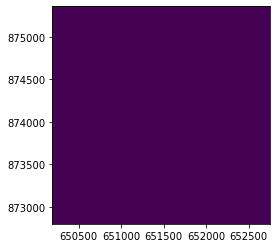

<AxesSubplot:>

In [93]:
rasterio.plot.show(sample_cloud)

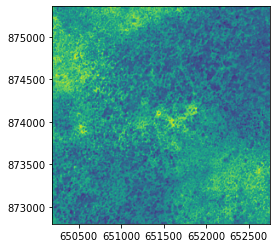

<AxesSubplot:>

In [120]:
rasterio.plot.show(rasterio.open('/Users/kendallsmith/Downloads/38NPP_29_20181231_B03_10m.tif', 'r'))